# EXPLORATION
# 10. 인물사진을 만들어보자[프로젝트]

In [1]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/aiffel_project/data/human_segmentation

Mounted at /content/drive
/content/drive/MyDrive/aiffel/aiffel_project/data/human_segmentation


In [2]:
%pip install pixellib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.3/430.3 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━

[pixellib import 문제 해결방법 출처](https://github.com/ayoolaolafenwa/PixelLib/issues/152)

In [3]:
import os
import fileinput

# Define the path to the file that needs to be modified
FILE_PATH = "/usr/local/lib/python3.10/dist-packages/pixellib/semantic/deeplab.py"

# Define the old and new strings that need to be replaced
OLD_STRING = "tensorflow.python.keras"
NEW_STRING = "tensorflow.keras"

# Use fileinput to replace the old string with the new string in the file
for line in fileinput.input(FILE_PATH, inplace=True):
    print(line.replace(OLD_STRING, NEW_STRING), end='')

# Define the old and new strings that need to be replaced
# This handles model loading errors
OLD_STRING = "tensorflow.keras.utils.layer_utils import get_source_inputs"
NEW_STRING = "tensorflow.python.keras.utils.layer_utils import get_source_inputs"

# Use fileinput to replace the old string with the new string in the file
for line in fileinput.input(FILE_PATH, inplace=True):
    print(line.replace(OLD_STRING, NEW_STRING), end='')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# %reset
# %who

In [5]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.7.0
0.7.1


## Step 1. 인물모드 직접 해 보기

### 1. 아웃포커싱 효과가 적용된 인물모드 사진

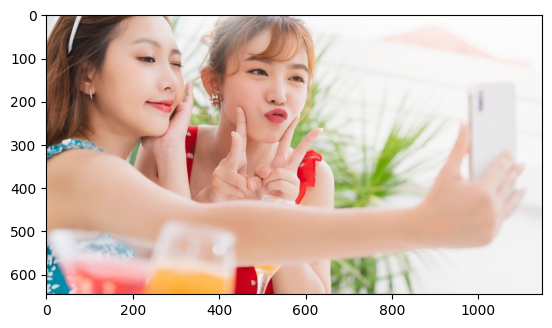

In [10]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

def show_img(img_path):
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    return img_rgb

img_path = 'images/2people.jpg'
img_rgb = show_img(img_path)

1/1 [==============================] - 12s 12s/step
person(15) is in [ 0 15]
인식 성공!


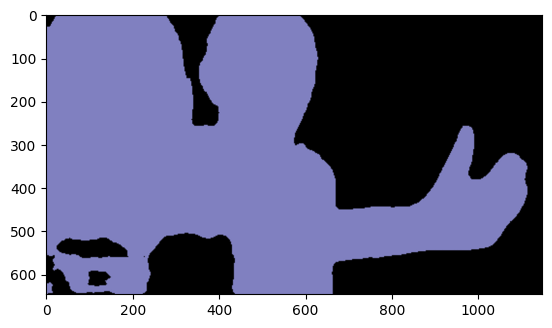

In [11]:
def image_segmentation(img_path, target_object):
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    model_dir = 'models'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    segvalues, output = model.segmentAsPascalvoc(img_path)

    index = LABEL_NAMES.index(target_object)
    if index in segvalues['class_ids']:
        print(f"{target_object}({index}) is in {segvalues['class_ids']}")
        print("인식 성공!")
        return segvalues, output, index
    else:
        raise ValueError("대상을 인식하지 못했습니다.")    

segvalues, output, index = image_segmentation(img_path, 'person')
plt.imshow(output)

(646, 1148)


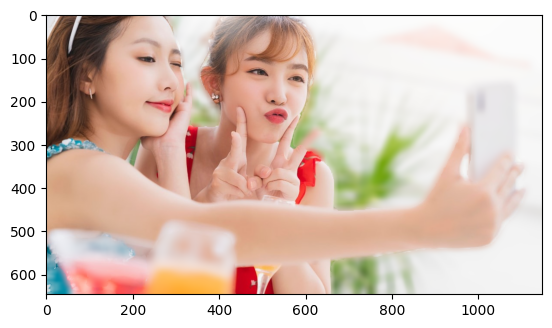

In [12]:
def make_bg_blur(img, output, index, blur):
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    colormap[:20]
    r, g, b = colormap[index]
    seg_color = (b,g,r)

    seg_map = np.all(output==seg_color, axis=-1) 
    print(seg_map.shape) 

    img_show = img.copy()
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    img_orig_blur = cv2.blur(img, (blur,blur))

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    img_concat = np.where(img_mask_color==255, img, img_bg_blur)

    return img_concat

img_result = make_bg_blur(img_rgb, output, index, 20)
plt.imshow(img_result)

### 2. 아웃포커싱 효과가 적용된 동물 사진

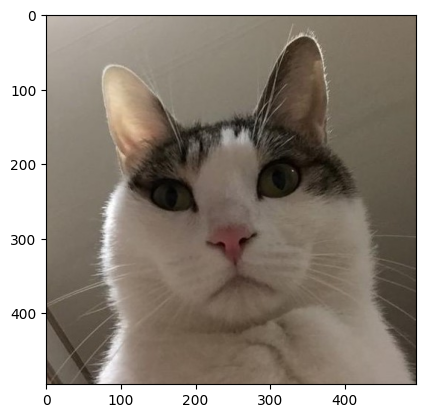

In [13]:
img_path = 'images/cat.jpg'
img_rgb = show_img(img_path)

1/1 [==============================] - 12s 12s/step
cat(8) is in [0 8]
인식 성공!


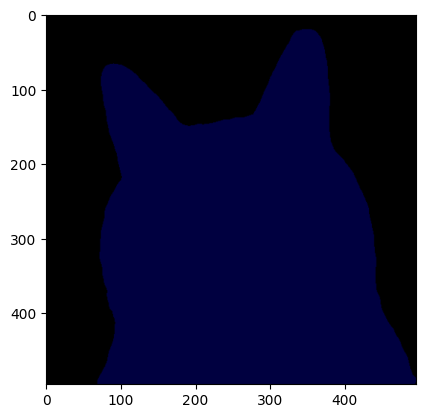

In [14]:
segvalues, output, index = image_segmentation(img_path, 'cat')
plt.imshow(output)

(496, 496)


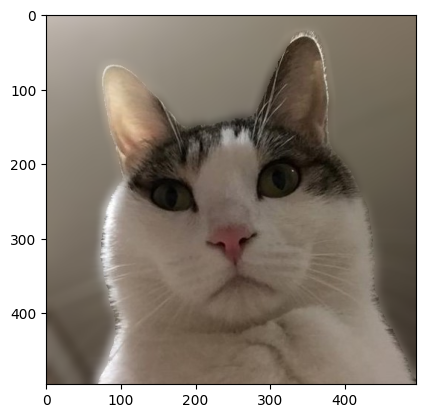

In [15]:
img_result = make_bg_blur(img_rgb, output, index, 20)
plt.imshow(img_result)

### 3. 배경을 다른 이미지로 바꿔보자

(720, 1280, 3)


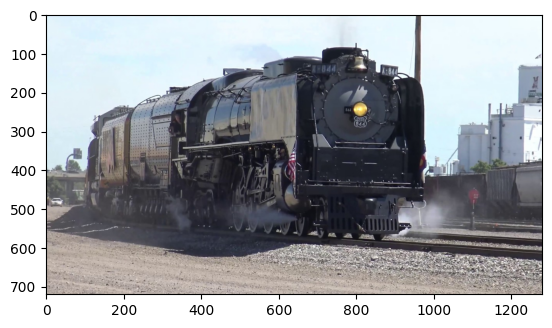

In [16]:
img_path = 'images/train.jpg'
img_rgb = show_img(img_path)
print(img_rgb.shape)

(302, 480, 3)


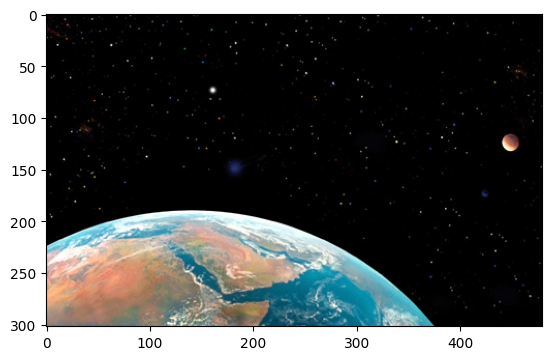

In [17]:
img_path2 = 'images/earth.jpg'
img_bg_rgb = show_img(img_path2)
print(img_bg_rgb.shape)

배경에 비해 기차의 이미지가 너무 크니 크기를 조정하겠습니다.

(302, 537, 3)


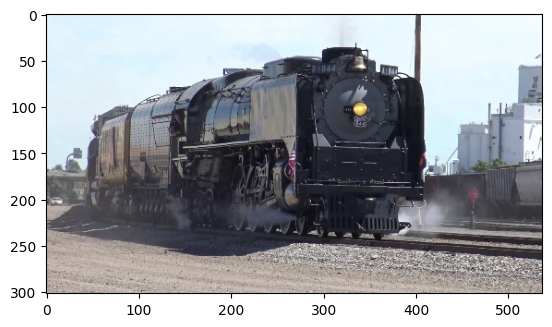

In [18]:
img_resize = cv2.resize(img_rgb, (0, 0), fx=img_bg_rgb.shape[0] / img_rgb.shape[0],
                                        fy=img_bg_rgb.shape[0] / img_rgb.shape[0])
plt.imshow(img_resize)
print(img_resize.shape)

세로 기준으로 맞췄으니 가로 사이즈를 줄이겠습니다.

(302, 480, 3)


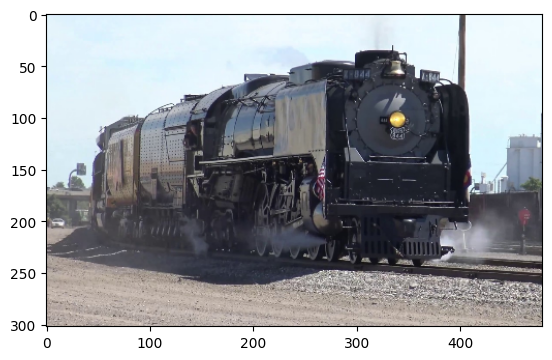

In [19]:
img_resize = img_resize[:, :img_bg_rgb.shape[1]]
plt.imshow(img_resize)
print(img_resize.shape)

In [20]:
img_path = 'images/train_resize.jpg'
cv2.imwrite(img_path, img_resize)

True

1/1 [==============================] - 11s 11s/step
train(19) is in [ 0 19]
인식 성공!


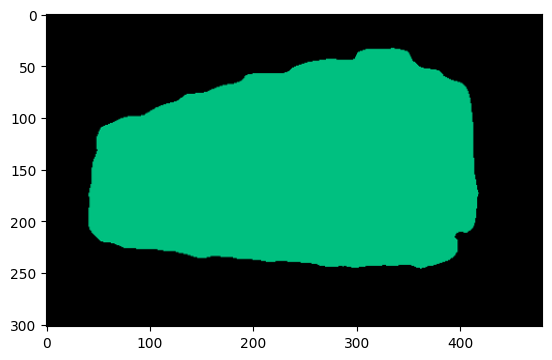

In [21]:
segvalues, output, index = image_segmentation(img_path, 'train')
plt.imshow(output)

(302, 480)


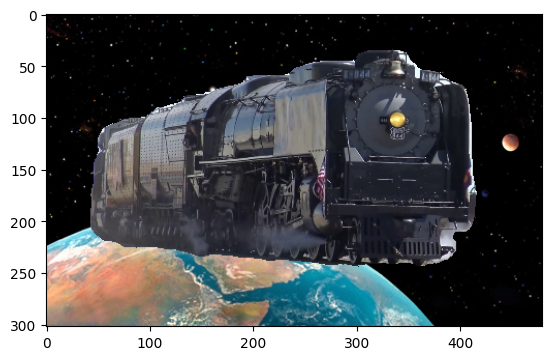

In [22]:
def change_bg(img, output, img_bg, blur, index):
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    colormap[:20]
    
    r, g, b = colormap[index]
    seg_color = (b,g,r)

    seg_map = np.all(output==seg_color, axis=-1) 
    print(seg_map.shape)

    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    img_concat = np.where(img_mask_color==255, img, img_bg)

    return img_concat

img_result = change_bg(img_resize, output, img_bg_rgb, 20, index)
plt.imshow(img_result)

은하철도 999가 완성됐습니다!

## Step 2. 사진에서 문제점 찾기

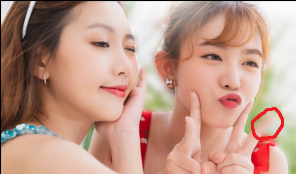

손가락이 배경으로 인식됐습니다.  
얼굴쪽 테두리도 자세히 보면 배경이 약간씩 사람으로 인식됐습니다.

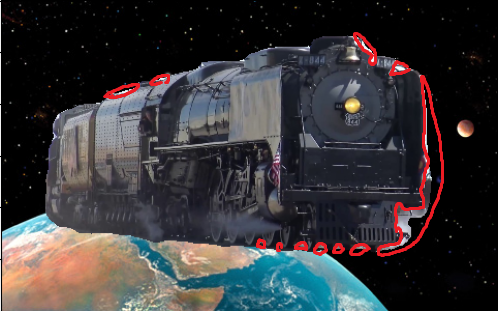

기차 이미지가 배경까지 함께 포함되어 나온 것이 확인됩니다.

## Step 3. 해결 방법을 제안해 보기

Semantic segmentation은 인식된 경계가 실제 경계와 차이가 존재하는 문제가 있습니다.  
이미지를 detection하는 과정에서 어떤 기술을 추가해야 할지는 고민을 해봤지만 명쾌한 방법을 찾지는 못했습니다.

다만 이미지 segmentation에 있어서 전처리, 혹은 후처리를 통해 이미지의 윤곽을 강조하고 노이즈를 제거함으로써(가우시안 필터링, 미디언 필터링 등의 필터링 등), 혹은 영상을 스무딩하여(민시프트, 군집화 등-속도 측면에서 너무 느릴 것 같습니다.) semantic segmentation 과정이 더 수월하게 진행되게 하거나 혹은 sementation을 통해 나온 결과물을 보정할 수 있을 것 같습니다. 